In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

In [22]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/vk_hack/vk_hack/1/train.csv')

In [23]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/vk_hack/vk_hack/1/test.csv')

<Axes: >

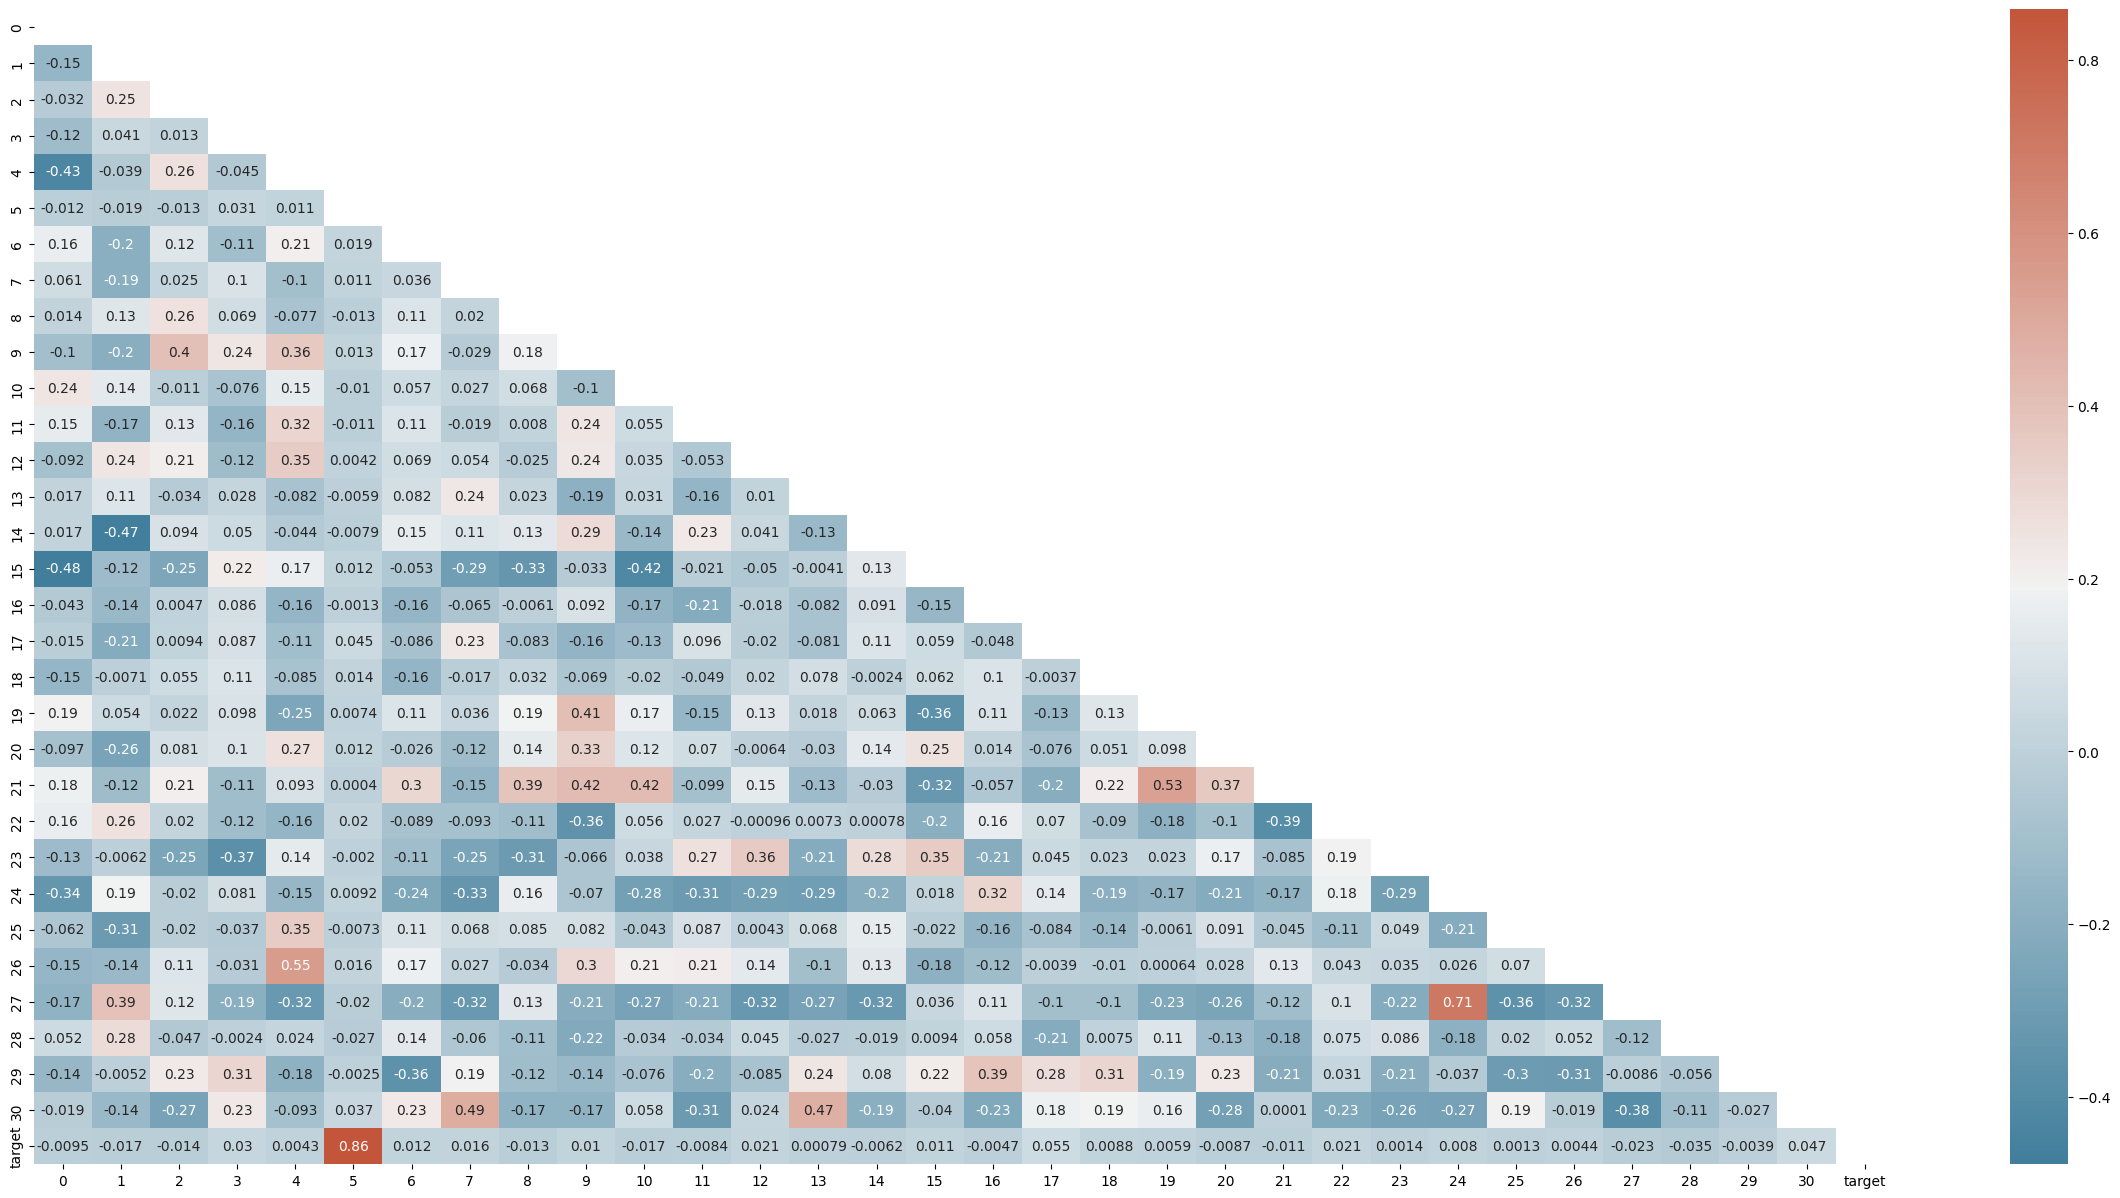

In [24]:

corr = df_train.corr()
f, ax = plt.subplots(figsize=(30, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [25]:
train_balanced = pd.concat([df_train[df_train['target'] == 0].sample(2000, random_state=42), df_train[df_train['target']==1]], axis=0)

In [26]:
X = train_balanced.drop(['target', '5'], axis=1)
y = train_balanced['target']

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
estimators = [
    (
        'lgbm1',
        LGBMClassifier(
            n_estimators=1000,
            max_depth=9,
            reg_lambda=20,
            verbose = -1,
            random_state=42,
        ),
    ),
    (

        'logreg1',
        Pipeline(
        [
        ('poly', PolynomialFeatures(2)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000)),
    ],
        )
    ),
    (

        'logreg2',
        Pipeline(
        [
        ('poly', PolynomialFeatures(2)),
        ('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=1000)),
    ],
        )
    ),
    (
        'lgbm',
        LGBMClassifier(
            n_estimators=1000,
            max_depth=7,
            reg_lambda=10,
            verbose = -1,
            random_state=42,
        ),
    ),
    (
        'svc',
        SVC(kernel='rbf', gamma=0.005, C=0.9, random_state=42),
    )
]


In [29]:
stack_model = StackingClassifier(
    estimators,
    CatBoostClassifier(
        n_estimators=100,
        max_depth=3,
        task_type='GPU',
        reg_lambda=20,
        verbose = 0,
        random_state=42,
    ),
)

stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('lgbm1',
                                LGBMClassifier(max_depth=9, n_estimators=1000,
                                               random_state=42, reg_lambda=20,
                                               verbose=-1)),
                               ('logreg1',
                                Pipeline(steps=[('poly', PolynomialFeatures()),
                                                ('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(max_iter=1000))])),
                               ('logreg2',
                                Pipeline(steps=[('poly', PolynomialFeatures()),
                                                ('scaler', MinMaxScaler()),
                                                ('logreg',
                                                 LogisticRegression(max_iter=1000))])),
                               ('lgbm',
                                LGBMClassifier(max_depth=7, n_estimators=1000,
                                               random_state=42, reg_lambda=10,
                                               verbose=-1)),
                               ('svc',
                                SVC(C=0.9, gamma=0.005, random_state=42))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7ac05cfba410>)

In [30]:
f1_score(y_train, stack_model.predict(X_train))

0.9710910786447

In [31]:
f1_score(y_val, stack_model.predict(X_val))

0.9255319148936171

In [32]:
recall_score(y_train, stack_model.predict(X_train))

0.9630086313193588

In [33]:
recall_score(y_val, stack_model.predict(X_val))

0.9206349206349206

In [34]:
precision_score(y_train, stack_model.predict(X_train))

0.9793103448275862

In [35]:
precision_score(y_val, stack_model.predict(X_val))

0.93048128342246

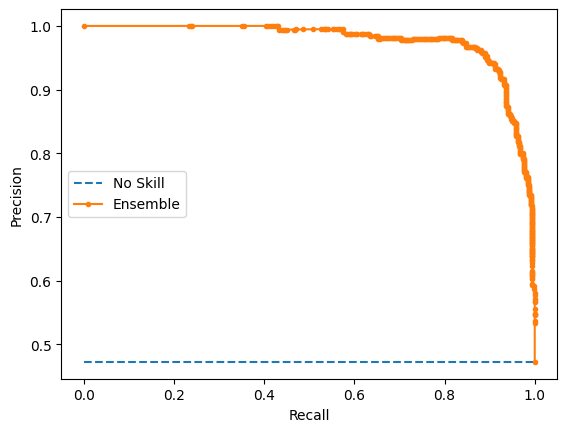

In [36]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
lr_probs = stack_model.predict_proba(X_val)
lr_probs = lr_probs[:, 1]

yhat = stack_model.predict(X_val)
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
lr_f1, lr_auc = f1_score(y_val, yhat), auc(lr_recall, lr_precision)

no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Ensemble')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [37]:
with open('lr_probs.npy', 'wb') as f:
    np.save(f, lr_probs)
with open('lr_probs.npy', 'rb') as f:
    lr = np.load(f)

In [38]:
with open('y_val.npy', 'wb') as f:
    np.save(f, y_val)
with open('y_val.npy', 'rb') as f:
    y_v = np.load(f)

In [39]:
X_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/vk_hack/vk_hack/1/test.csv')
X_test = X_test.drop(['5'], axis=1)

In [40]:
pd.DataFrame(stack_model.predict(X_test), columns=['target']).to_csv('ensemble_lgbm_logreg_svc.csv', index=False)